
<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 27

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
- Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
```
git reset --hard origin/main
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

# We will use tensorflow for this lecture. Sometimes Tensorflow can be verbose with its warning messages.
# We will suppress these messages with the following code:
import warnings
warnings.filterwarnings('ignore')

## Outline for today

* Introduction to Artificial Neural Networks

**Reading material**: This notebook + (ANNs in Chapter 13)

## Today is our first lecture on artificial neural networks

We will introduce the basic idea behind **Artificial Neural Networks** (ANNs), and we will continue to refine these ideas in the next lectures.

We will use the `pytorch` package to train neural networks.

### Preliminaries: Dataset generation and pytorch considerations

Let's start by creating a simple one-dimensional dataset.

As in previous lectures, we will create a noiseless and a noisy dataset.

The **note below** includes the usual dataset for the ground-truth function $f(x)=x\sin{x}$.

(the code is omitted for brevity).

In [2]:
seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

from sklearn.model_selection import train_test_split

# Function to "learn"
def f(x):
    return x * np.sin(x)

n_data = 50 # number of points in our dataset
testset_ratio = 0.90 # ratio of test set points from the dataset
x_data = np.linspace(0, 10, n_data) # uniformly spaced points
y_data = f(x_data) # function values at x_data

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes
Y_data = np.reshape(y_data,(-1,1)) # a 2D array that scikit-learn likes

# Now let's also create a noisy dataset:
random_std = 0.5 + 1.0 * np.random.random(y_data.shape) # np.random.random returns random number between [0.0, 1.0)
noise = np.random.normal(0, random_std) # sample vector from Gaussians with random standard deviation
#
y_noisy_data = y_data + noise
Y_noisy_data = np.reshape(y_noisy_data,(-1,1)) # a 2D array that scikit-learn likes
#
# Pair up noiseless points with their associated noise level (because of train_test_split):
Y_and_noise_data = np.column_stack((y_data,noise))

# Let's split into training points and the rest for testing:
X_train, X_test, Y_and_noise_train, Y_and_noise_test = train_test_split(X_data,
                                                              Y_and_noise_data,
                                                              test_size=testset_ratio,
                                                              random_state=seed)

y_train = Y_and_noise_train[:,0] # noiseless training data ouput
noise_train = Y_and_noise_train[:,1] # noise of training data points
y_noisy_train = y_train + noise_train # noisy training data ouput (perturbed noiseless data by Gaussian noise)

y_test = Y_and_noise_test[:,0] # noiseless testing data output
noise_test = Y_and_noise_test[:,1] # noise of testing data points
y_noisy_test = y_test + noise_test # noisy testing data output (perturbed noiseless data by Gaussian noise)

In [3]:
# Let's make sure that we have 1D arrays and 2D arrays for the inputs and outputs
# We have X_train and X_test as 2D arrays of the one-dimensional input, but we will use 1D arrays for plotting:
x_train = X_train.ravel() # transforms 2D array in 1D array
x_test = X_test.ravel()   # transforms 2D array in 1D array

# We have noiseless data y_train and y_test as 1D arrays but pytorch needs them in 2D shape:
Y_train = np.reshape(y_train,(-1,1)) # transforms 1D array in 2D array (IMPORTANT for pytorch!)
Y_test = np.reshape(y_test,(-1,1))   # transforms 1D array in 2D array (IMPORTANT for pytorch!)

# We have the noisy data y_noisy_train, y_noisy_test and y_data as 1D arrays but pytorch needs them in 2D shape:
Y_noisy_train = np.reshape(y_noisy_train,(-1,1)) # transforms 1D array in 2D array (IMPORTANT for pytorch!)
Y_noisy_test = np.reshape(y_noisy_test,(-1,1))   # transforms 1D array in 2D array (IMPORTANT for pytorch!)
Y_noisy_data = np.reshape(y_noisy_data,(-1,1))   # transforms 1D array in 2D array (IMPORTANT for pytorch!)

<div class="alert alert-block alert-info"><b>Remark 1: pytorch handles one-dimensional inputs and outputs as <font color=red>2D arrays</font>. </div>

So, the dataset obtained from $f(x)=x\sin{x}$ (created in the above notes and omitted from the presentation) is saved considering both formats:

* `x_data`, `x_train`, `x_test`, and corresponding 2D arrays: `X_data`, `X_train`, `X_test`

* `y_data`, `y_train`, `y_test`, and corresponding 2D arrays: `Y_data`, `Y_train`, `Y_test`

* `y_noisy_data`, `y_noisy_train`, `y_noisy_test`, and corresponding 2D arrays: `Y_noisy_data`, `Y_noisy_train`, `Y_noisy_test`

* Other packages that we considered previously in the course (e.g. Gaussian processes with scikit-learn) handled one-dimensional outputs as a 1D vector (e.g., `y_data`).

* Be <font color=red>careful</font> with the syntax requirements when you are using a new package...

Recall that in this course we use the following notation:

* Lowercase variables like `x_data` indicate a 1D array, while uppercase variables like `X_data` indicate a 2D array.

In [4]:
print("Here's a print of y_train:\n", y_train)

print("Here's a print of Y_train:\n", Y_train)

Here's a print of y_train:
 [-0.97986787  6.45845766  5.41163154  0.80179828  3.86684455]
Here's a print of Y_train:
 [[-0.97986787]
 [ 6.45845766]
 [ 5.41163154]
 [ 0.80179828]
 [ 3.86684455]]


As usual, let's standardize the dataset. This is good practice and is important when training neural networks.

In [5]:
# Standardize your dataset is good practice and can be important for ANNs!
from sklearn.preprocessing import StandardScaler # standardize the dataset with scikit-learn
import torch
#
scaler_x = StandardScaler().fit(X_train) # Check scikit-learn to see what this does!
#
X_train_scaled_np=scaler_x.transform(X_train) # the _np index it's to highlight this is a numpy array
X_test_scaled_np=scaler_x.transform(X_test)   # the _np index it's to highlight this is a numpy array
X_data_scaled_np=scaler_x.transform(X_data)   # the _np index it's to highlight this is a numpy array

scaler_y_noiseless = StandardScaler().fit(Y_train) # Check scikit-learn to see what this does!
#
Y_train_scaled_np=scaler_y_noiseless.transform(Y_train) # the _np index it's to highlight this is a numpy array
Y_test_scaled_np=scaler_y_noiseless.transform(Y_test)   # the _np index it's to highlight this is a numpy array
Y_data_scaled_np=scaler_y_noiseless.transform(Y_data)   # the _np index it's to highlight this is a numpy array
#
scaler_y_noisy = StandardScaler().fit(Y_noisy_train) # Check scikit-learn to see what this does!
#
Y_noisy_train_scaled_np=scaler_y_noisy.transform(Y_noisy_train) # the _np index it's to highlight this is a numpy array
Y_noisy_test_scaled_np=scaler_y_noisy.transform(Y_noisy_test)   # the _np index it's to highlight this is a numpy array
Y_noisy_data_scaled_np=scaler_y_noisy.transform(Y_noisy_data)   # the _np index it's to highlight this is a numpy array

<div class="alert alert-block alert-info"><b>Remark 2: pytorch handles <font color=red>torch tensors</font> instead of <font color=blue>numpy arrays</font>. So, we need to convert numpy data accordingly!</div>

In [6]:
# Convert all data from numpy arrays to torch tensors
X_train_scaled = torch.from_numpy(X_train_scaled_np).float()
X_test_scaled  = torch.from_numpy(X_test_scaled_np).float()
X_data_scaled  = torch.from_numpy(X_data_scaled_np).float()
# Same thing for noiseless data output
Y_train_scaled = torch.from_numpy(Y_train_scaled_np).float()
Y_test_scaled  = torch.from_numpy(Y_test_scaled_np).float()
Y_data_scaled  = torch.from_numpy(Y_data_scaled_np).float()
# Same thing for noisy data output
Y_noisy_train_scaled = torch.from_numpy(Y_noisy_train_scaled_np).float()
Y_noisy_test_scaled  = torch.from_numpy(Y_noisy_test_scaled_np).float()
Y_noisy_data_scaled  = torch.from_numpy(Y_noisy_data_scaled_np).float()

But be careful... Let's check the python output of a numpy array versus a torch tensor for the same variable:

In [7]:
print("Here's a print of the numpy array Y_train_scaled_np:\n", Y_train_scaled_np)

print("\nHere's a print of the torch tensor for the same variable:\n", Y_train_scaled)

Here's a print of the numpy array Y_train_scaled_np:
 [[-1.46247053]
 [ 1.19620179]
 [ 0.82203591]
 [-0.8256516 ]
 [ 0.26988443]]

Here's a print of the torch tensor for the same variable:
 tensor([[-1.4625],
        [ 1.1962],
        [ 0.8220],
        [-0.8257],
        [ 0.2699]])


<div class="alert alert-block alert-info"><b>Remark 3: It's common practice to use <font color=red>torch tensors with SINGLE precision</font> (i.e. dtype=float32) instead of DOUBLE precision (i.e., dtype=float64)</div>

Single precision (float32) is the default for training neural networks because it:

* Accelerates computations

* Uses less memory

* Works well with GPUs (which are optimized for float32)

However, note that using single precision has important consequences!

In [8]:
# Numpy arrays are double precision by default (i.e. they have precision up to about 15 digits)
a_np = np.array([0.12345123451234512345])   # saving a numpy array with 20 digits (12345 repeated 4 times)

# When we convert this to a torch tensor with single precision, it has about 7 digits of precision
a_torch = torch.from_numpy(a_np).float()    # the float() command converts into a float32 number

print("Print 20 digits of the numpy array number  : %0.20f" % a_np)  # [0.123451234512345]
print("Print 20 digits of the torch tensor number : %0.20f" % a_torch)  # tensor([0.1235])

Print 20 digits of the numpy array number  : 0.12345123451234511769
Print 20 digits of the torch tensor number : 0.12345123291015625000


* The numpy array number is correct in the first **16 decimal digits** but the remaining digits are incorrect
    - <font color=green>0.1234512345123451</font><font color=red>1769</font>

* The torch number is only correct in the first **8 decimal digits** but the remaining digits are incorrect
    - <font color=green>0.12345123</font><font color=red>291015625000</font>

In [9]:
# However, we can also convert to a torch tensor with DOUBLE PRECISION
a_torch_double = torch.from_numpy(a_np).double()    # the double() command converts into a float64 number

print("Print 20 digits of the numpy array number                      : %0.20f" % a_np)
print("Print 20 digits of the torch tensor number in double precision : %0.20f" % a_torch_double)

Print 20 digits of the numpy array number                      : 0.12345123451234511769
Print 20 digits of the torch tensor number in double precision : 0.12345123451234511769


Now we see that the torch tensor and the numpy array have exactly the same precision (16 decimal digits, with the remaining digits being incorrect).

* We follow common practice and **use single precision when training neural networks**, unless otherwise stated.

## Short tutorial on 1D regression with Artificial Neural Networks

ANNs for regression are not that different when compared to linear regression.

Consider again the observation distribution as we wrote it in the beginning of the course:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

But now, instead of modeling the mean of the distribution using polynomial basis functions by $f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x)$, consider a simple extension where the **basis functions also have their own parameters**:

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

where $\mathbf{z} = (\mathbf{z}_1,\, \mathbf{z}_2)$ and $\mathbf{z}_1 = (\mathbf{w},\, \mathbf{b})$ are all the parameters of the model.

Instead of stopping here,

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

we can also repeat this recursively $L$ times to create more complex transformations:

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(x\right)\right)\cdots\right)\right)
$$

where $f_l(x) = f(x;\, \mathbf{z}_l)$ is the function at layer $l$ of our recursive transformation.

This is the key idea behind **deep neural networks**.

* Confused?

Let's try to see this for a very simple case. Consider again the observation distribution:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

The simplest extension comes from using a nonlinear function $f_1$ acting on our well-known linear model:

$$
\mu_{y|z} = f(x;\, \mathbf{z}) = f_1\left( \mathbf{w}^T \boldsymbol{\phi}(x) \right) = f_1\left( f_0 \left(x; \mathbf{z}_0 \right) \right) = f_1\left(b_0 + w_0 x\right)
$$

where we are calling our linear regression model as $f_0 \left(x; \mathbf{z}_0 \right)$.

So, our model for the mean of the observation distribution becomes:

$$
\mu_{y|z} = f_1\left( b_0 + w_0 x \right)
$$

Does this remind you of a model we discussed before?

* If $f_1$ is the sigmoid function, then this is what we used in Logistic Regression!
    * Of course, in that case, the observation distribution was the Bernoulli distribution (instead of the Gaussian distribution) because it was a classification problem, and the mean was the $\rho$ parameter. 

Anyway, back to our model for the mean of our Gaussian observation distribution:

$$
\mu_{y|z} = f_1\left( b_0 + w_0 x \right)
$$

Why stop here?

Why not introducing more parameters?

$$
\mu_{y|z} = b_1 + w_1 f_1\left( b_0 + w_0 x \right)
$$

But why stop here?

What if we apply another nonlinear function $f_2$?

$$
\mu_{y|z} = f_2\left(b_1 + w_1 f_1\left( b_0 + w_0 x \right)\right)
$$

But why stop here?

What about doing this recursively $L$ times to create more complex transformations?

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(b_0 + w_0 x\right)\right)\cdots\right)\right)
$$

This is one of the simplest examples of an Artificial Neural Network architecture: the **feedforward architecture**.

We will look into this model carefully in the next lectures.

For now, I just want to draw a schematic so that you understand the number of parameters that starts appearing!

* Draw on the board a feedforward ANN with 2 hidden layers for 1D case.
    * First hidden layer with 3 neurons and second hidden layer with 2 neurons.

Two examples of nonlinear activation functions $f_l$ for a layer $l$.


<div>
<img style="float: left"; src=../figures/nonlin_fn.png width=500px></div>

Let's now focus on how to create an ANN model for 1D regression using:
1. A feedforward architecture with 2 dense hidden layers
2. The ReLu activation function for each hidden layer

We will use [pytorch](https://pytorch.org/). In this package, we usually define the neural network architecture by a python class.

In [10]:
import torch.nn as nn
# A simple Feedforward neural network template. This code is longer than needed.
class ANN_verbose(nn.Module):         # I named this class ANN_verbose
    def __init__(self,                # we need this to refer to the class itself
                 input_dimensions=1,  # input x is one-dimensional (by default)
                 neurons1=3,          # 1st hidden layer will have 3 neurons (by default)
                 neurons2=2,          # 2nd hidden layer will have 2 neurons (by default)
                 output_dimensions=1):# output y is one-dimensional (by default)
        super().__init__() # This is needed to inherit what is contained in nn.Module
        
        # Define each fully connected layer (linear transformation of incoming data y=x*A^T+b)
        self.fc1 = nn.Linear(input_dimensions, neurons1)  # 1st hidden layer
        self.fc2 = nn.Linear(neurons1, neurons2)          # 2nd hidden layer
        self.fc3 = nn.Linear(neurons2, output_dimensions) # Output layer
        
        # Define activation function
        self.act = nn.ReLU()
        
    def forward(self, x):
        # Flow of data through the network
        x = self.fc1(x) # the incoming data x is passed to the next layer (1st hidden layer)
        x = self.act(x) # then through the activation function for all neurons of that layer
        x = self.fc2(x) # then the data continues through the next layer (2nd hidden layer)
        x = self.act(x) # then through the activation function of this layer. Note that we
                        #are using the same activation function for 1st & 2nd hidden layers
        x = self.fc3(x) # then the data gets to the last layer. Note that because we are
                        #doing regression, we don't need to define the activation function
                        #for this last layer (it is a linear activation function)
        return x
ANN_verbose() # This is just to output the class

ANN_verbose(
  (fc1): Linear(in_features=1, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=1, bias=True)
  (act): ReLU()
)

Check the `torch.nn` module's [documentation](https://docs.pytorch.org/docs/stable/nn.html).

This module has a lot of functions!

In the code above we use `nn.Module`, `nn.Linear`, `nn.ReLU`. Check what they are in the documentation!

* For example, after reading the documentation it should be obvious how to choose the tanh activation function instead of the ReLU.

In my research group we use pytorch (and many other packages) extensively. However, these lectures focus on the fundamentals and we only explicitly cover simple neural network architectures.

* For your Final Projects, you are welcome to explore this and other packages to use more architectures!

In [11]:
# We can write shorter code by using nn.Sequential
import torch.nn as nn # import the basic class

class ANN(nn.Module):
    def __init__(self, input_dimensions=1, neurons1=3, neurons2=2, output_dimensions=1):
        super().__init__()
        
        # Pack everything into nn.Sequential
        self.net = nn.Sequential(
            nn.Linear(input_dimensions, neurons1),
            nn.Tanh(), # Try to change from nn.ReLU() to nn.Tanh()
            nn.Linear(neurons1, neurons2),
            nn.Tanh(), # Try to change from nn.ReLU() to nn.Tanh()
            nn.Linear(neurons2, output_dimensions)
        )
        
    def forward(self, x):
        return self.net(x)
# Show the ANN model:
ANN()

ANN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=3, bias=True)
    (1): Tanh()
    (2): Linear(in_features=3, out_features=2, bias=True)
    (3): Tanh()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)

And now we just need to define two things:
1. The loss function: for regression, typically we use the MSE loss
2. The optimizer: a common choice is Adam

Furthermore, instead of using the default number of neurons defined in our ANN class, let's create a model with:
* 5 neurons for the 1st hidden layer
* 3 neurons for the 2nd hidden layer.

In [12]:
# Now create your first ANN model!
neurons1=5 # number of neurons for the first hidden layer
neurons2=3 # number of neurons for the second hidden layer
epochs = 1000 # number of times we train the neural network with the entire training set
ANN_model = ANN(
    input_dimensions=1,
    neurons1=neurons1,
    neurons2=neurons2,
    output_dimensions=1
) # play with this 

# import optimizer from torch to optimize 
from torch.optim import Adam

# define the optimizer (in this case Adam with 0.01 learning rate as hyperparameter)
optimizer = Adam(ANN_model.parameters(), lr=0.01,)# play with the learning rate value

# define the loss function (using MSE Loss for this case)
loss_fn = nn.MSELoss()

In [13]:
# Train the network and save the loss values

# Lists to store losses for plotting later
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # --- Training ---
    ANN_model.train()  # Set to training mode
    Y_train_scaled_pred = ANN_model(X_train_scaled)  # Forward pass
    #preds = ANN_model(torch.from_numpy(X_data).float())  # Forward pass
    loss = loss_fn(Y_train_scaled_pred, Y_train_scaled)  # Compute loss
    #loss = loss_fn(preds, torch.from_numpy(y_data).float())  # Compute loss

    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Backward pass
    optimizer.step()       # Update parameters

    train_losses.append(loss.item())  # Save training loss

    # --- Validation ---
    ANN_model.eval()
    with torch.no_grad():
        Y_test_scaled_pred = ANN_model(X_test_scaled)
        #val_preds = ANN_model(torch.from_numpy(X_test).float())
        val_loss = loss_fn(Y_test_scaled_pred, Y_test_scaled).item()

    val_losses.append(val_loss)  # Save validation loss

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")

Epoch [1/1000] Train Loss: 1.2157 | Val Loss: 3.5364
Epoch [2/1000] Train Loss: 1.1706 | Val Loss: 3.4134
Epoch [3/1000] Train Loss: 1.1280 | Val Loss: 3.2948
Epoch [4/1000] Train Loss: 1.0880 | Val Loss: 3.1813
Epoch [5/1000] Train Loss: 1.0509 | Val Loss: 3.0734
Epoch [6/1000] Train Loss: 1.0166 | Val Loss: 2.9713
Epoch [7/1000] Train Loss: 0.9851 | Val Loss: 2.8754
Epoch [8/1000] Train Loss: 0.9562 | Val Loss: 2.7858
Epoch [9/1000] Train Loss: 0.9298 | Val Loss: 2.7022
Epoch [10/1000] Train Loss: 0.9054 | Val Loss: 2.6246
Epoch [11/1000] Train Loss: 0.8827 | Val Loss: 2.5525
Epoch [12/1000] Train Loss: 0.8614 | Val Loss: 2.4856
Epoch [13/1000] Train Loss: 0.8410 | Val Loss: 2.4237
Epoch [14/1000] Train Loss: 0.8213 | Val Loss: 2.3663
Epoch [15/1000] Train Loss: 0.8020 | Val Loss: 2.3130
Epoch [16/1000] Train Loss: 0.7828 | Val Loss: 2.2636
Epoch [17/1000] Train Loss: 0.7636 | Val Loss: 2.2178
Epoch [18/1000] Train Loss: 0.7443 | Val Loss: 2.1753
Epoch [19/1000] Train Loss: 0.7246 | 

Epoch [334/1000] Train Loss: 0.1277 | Val Loss: 1.3894
Epoch [335/1000] Train Loss: 0.1276 | Val Loss: 1.3891
Epoch [336/1000] Train Loss: 0.1274 | Val Loss: 1.3889
Epoch [337/1000] Train Loss: 0.1273 | Val Loss: 1.3886
Epoch [338/1000] Train Loss: 0.1271 | Val Loss: 1.3883
Epoch [339/1000] Train Loss: 0.1270 | Val Loss: 1.3881
Epoch [340/1000] Train Loss: 0.1268 | Val Loss: 1.3879
Epoch [341/1000] Train Loss: 0.1267 | Val Loss: 1.3876
Epoch [342/1000] Train Loss: 0.1265 | Val Loss: 1.3874
Epoch [343/1000] Train Loss: 0.1264 | Val Loss: 1.3871
Epoch [344/1000] Train Loss: 0.1262 | Val Loss: 1.3869
Epoch [345/1000] Train Loss: 0.1261 | Val Loss: 1.3866
Epoch [346/1000] Train Loss: 0.1260 | Val Loss: 1.3864
Epoch [347/1000] Train Loss: 0.1258 | Val Loss: 1.3862
Epoch [348/1000] Train Loss: 0.1257 | Val Loss: 1.3860
Epoch [349/1000] Train Loss: 0.1255 | Val Loss: 1.3857
Epoch [350/1000] Train Loss: 0.1254 | Val Loss: 1.3855
Epoch [351/1000] Train Loss: 0.1252 | Val Loss: 1.3853
Epoch [352

Epoch [665/1000] Train Loss: 0.0792 | Val Loss: 1.3532
Epoch [666/1000] Train Loss: 0.0790 | Val Loss: 1.3517
Epoch [667/1000] Train Loss: 0.0789 | Val Loss: 1.3501
Epoch [668/1000] Train Loss: 0.0787 | Val Loss: 1.3485
Epoch [669/1000] Train Loss: 0.0786 | Val Loss: 1.3469
Epoch [670/1000] Train Loss: 0.0784 | Val Loss: 1.3452
Epoch [671/1000] Train Loss: 0.0783 | Val Loss: 1.3435
Epoch [672/1000] Train Loss: 0.0781 | Val Loss: 1.3417
Epoch [673/1000] Train Loss: 0.0779 | Val Loss: 1.3399
Epoch [674/1000] Train Loss: 0.0778 | Val Loss: 1.3381
Epoch [675/1000] Train Loss: 0.0776 | Val Loss: 1.3362
Epoch [676/1000] Train Loss: 0.0774 | Val Loss: 1.3343
Epoch [677/1000] Train Loss: 0.0772 | Val Loss: 1.3323
Epoch [678/1000] Train Loss: 0.0770 | Val Loss: 1.3302
Epoch [679/1000] Train Loss: 0.0768 | Val Loss: 1.3281
Epoch [680/1000] Train Loss: 0.0766 | Val Loss: 1.3259
Epoch [681/1000] Train Loss: 0.0764 | Val Loss: 1.3237
Epoch [682/1000] Train Loss: 0.0762 | Val Loss: 1.3214
Epoch [683

In [14]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_ANN.plot(train_losses) # plot training loss
ax1_ANN.plot(val_losses) # plot testing loss
ax1_ANN.set_title('Training and testing loss', fontsize=20)
ax1_ANN.set_ylabel('loss', fontsize=20)
ax1_ANN.set_xlabel('epoch', fontsize=20)
ax1_ANN.legend(['training', 'testing'], loc='upper right', fontsize=15)

# Create a plot for the ANN prediction
ax2_ANN.plot(x_data, y_data, 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_ANN.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # show testing data

# Let's predict all data points from our trained ANN:
Y_data_scaled_pred = ANN_model(X_data_scaled).detach() # detach() is to only get the values without asking for
                                                       #the complete computational graph of pytorch
Y_data_pred = scaler_y_noiseless.inverse_transform(Y_data_scaled_pred) # this is to unscale the data

ax2_ANN.plot(x_data, Y_data_pred.ravel(), 'b-', label="Neural Network prediction") # plot prediction
ax2_ANN.set_title(r'ANN with '+str(neurons1)+' neurons in 1st hidden layer & '+str(neurons2)+' neurons in the 2nd',
                 fontsize=20)
ax2_ANN.set_xlabel('$x$', fontsize=20)
ax2_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_ANN.legend(loc='upper left', fontsize=15)

# Create figure with specified size
fig_ANN.set_size_inches(16, 8)
plt.close(fig_ANN) # do not plot the figure now. We will show it in the next cell

**Note**: It can be instructive to calculate the number of parameters of a fully connected feedforward neural network.

If the network has $L$ hidden layers, the total number $P$ of trainable parameters of the network is:

$$P = \sum_{l=0}^L(n_l \times n_{l+1}+n_{l+1})$$

Our network has $L=2$, so:

$$P = (n_0\times n_1+n_1)+(n_1\times n_2+n_2)+(n_2\times n_3+n_3)$$

where $n_0=1$ is the number of input neurons, $n_1=5$ is the number of neurons in the 1st hidden layer, $n_2=3$ is the number of neurons in the 2nd hidden layer, and $n_3=1$ is the number of output neurons.

In [15]:
# This code is hidden in the notes. It prints the number of neural networks parameters
n=np.array([1,neurons1,neurons2,1])
P = 0
for l in range(0,3):
    P += (n[l]*n[l+1]+n[l+1])
print(P)

32


We could also find the parameters directly from pytorch!

In [16]:
# The following 2 lines show all the parameters of the network after training:
for parameter in ANN_model.parameters():
    print(parameter)

Parameter containing:
tensor([[ 1.0827],
        [-2.5413],
        [ 2.0931],
        [ 2.2635],
        [-1.0497]], requires_grad=True)
Parameter containing:
tensor([ 1.6590,  0.2934, -2.0344,  0.2653,  1.0209], requires_grad=True)
Parameter containing:
tensor([[-0.6635, -0.6039, -1.0612,  0.3149,  1.1452],
        [-0.7645,  1.8642, -1.6688, -1.3368,  0.2696],
        [-0.3296,  1.5474, -0.4141, -1.7191,  0.5296]], requires_grad=True)
Parameter containing:
tensor([-0.5651,  0.3945,  0.2358], requires_grad=True)
Parameter containing:
tensor([[ 1.6329, -0.8276, -0.6766]], requires_grad=True)
Parameter containing:
tensor([-0.4775], requires_grad=True)


In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Our ANN has %i trainable parameters." % count_parameters(ANN_model))

Our ANN has 32 trainable parameters.


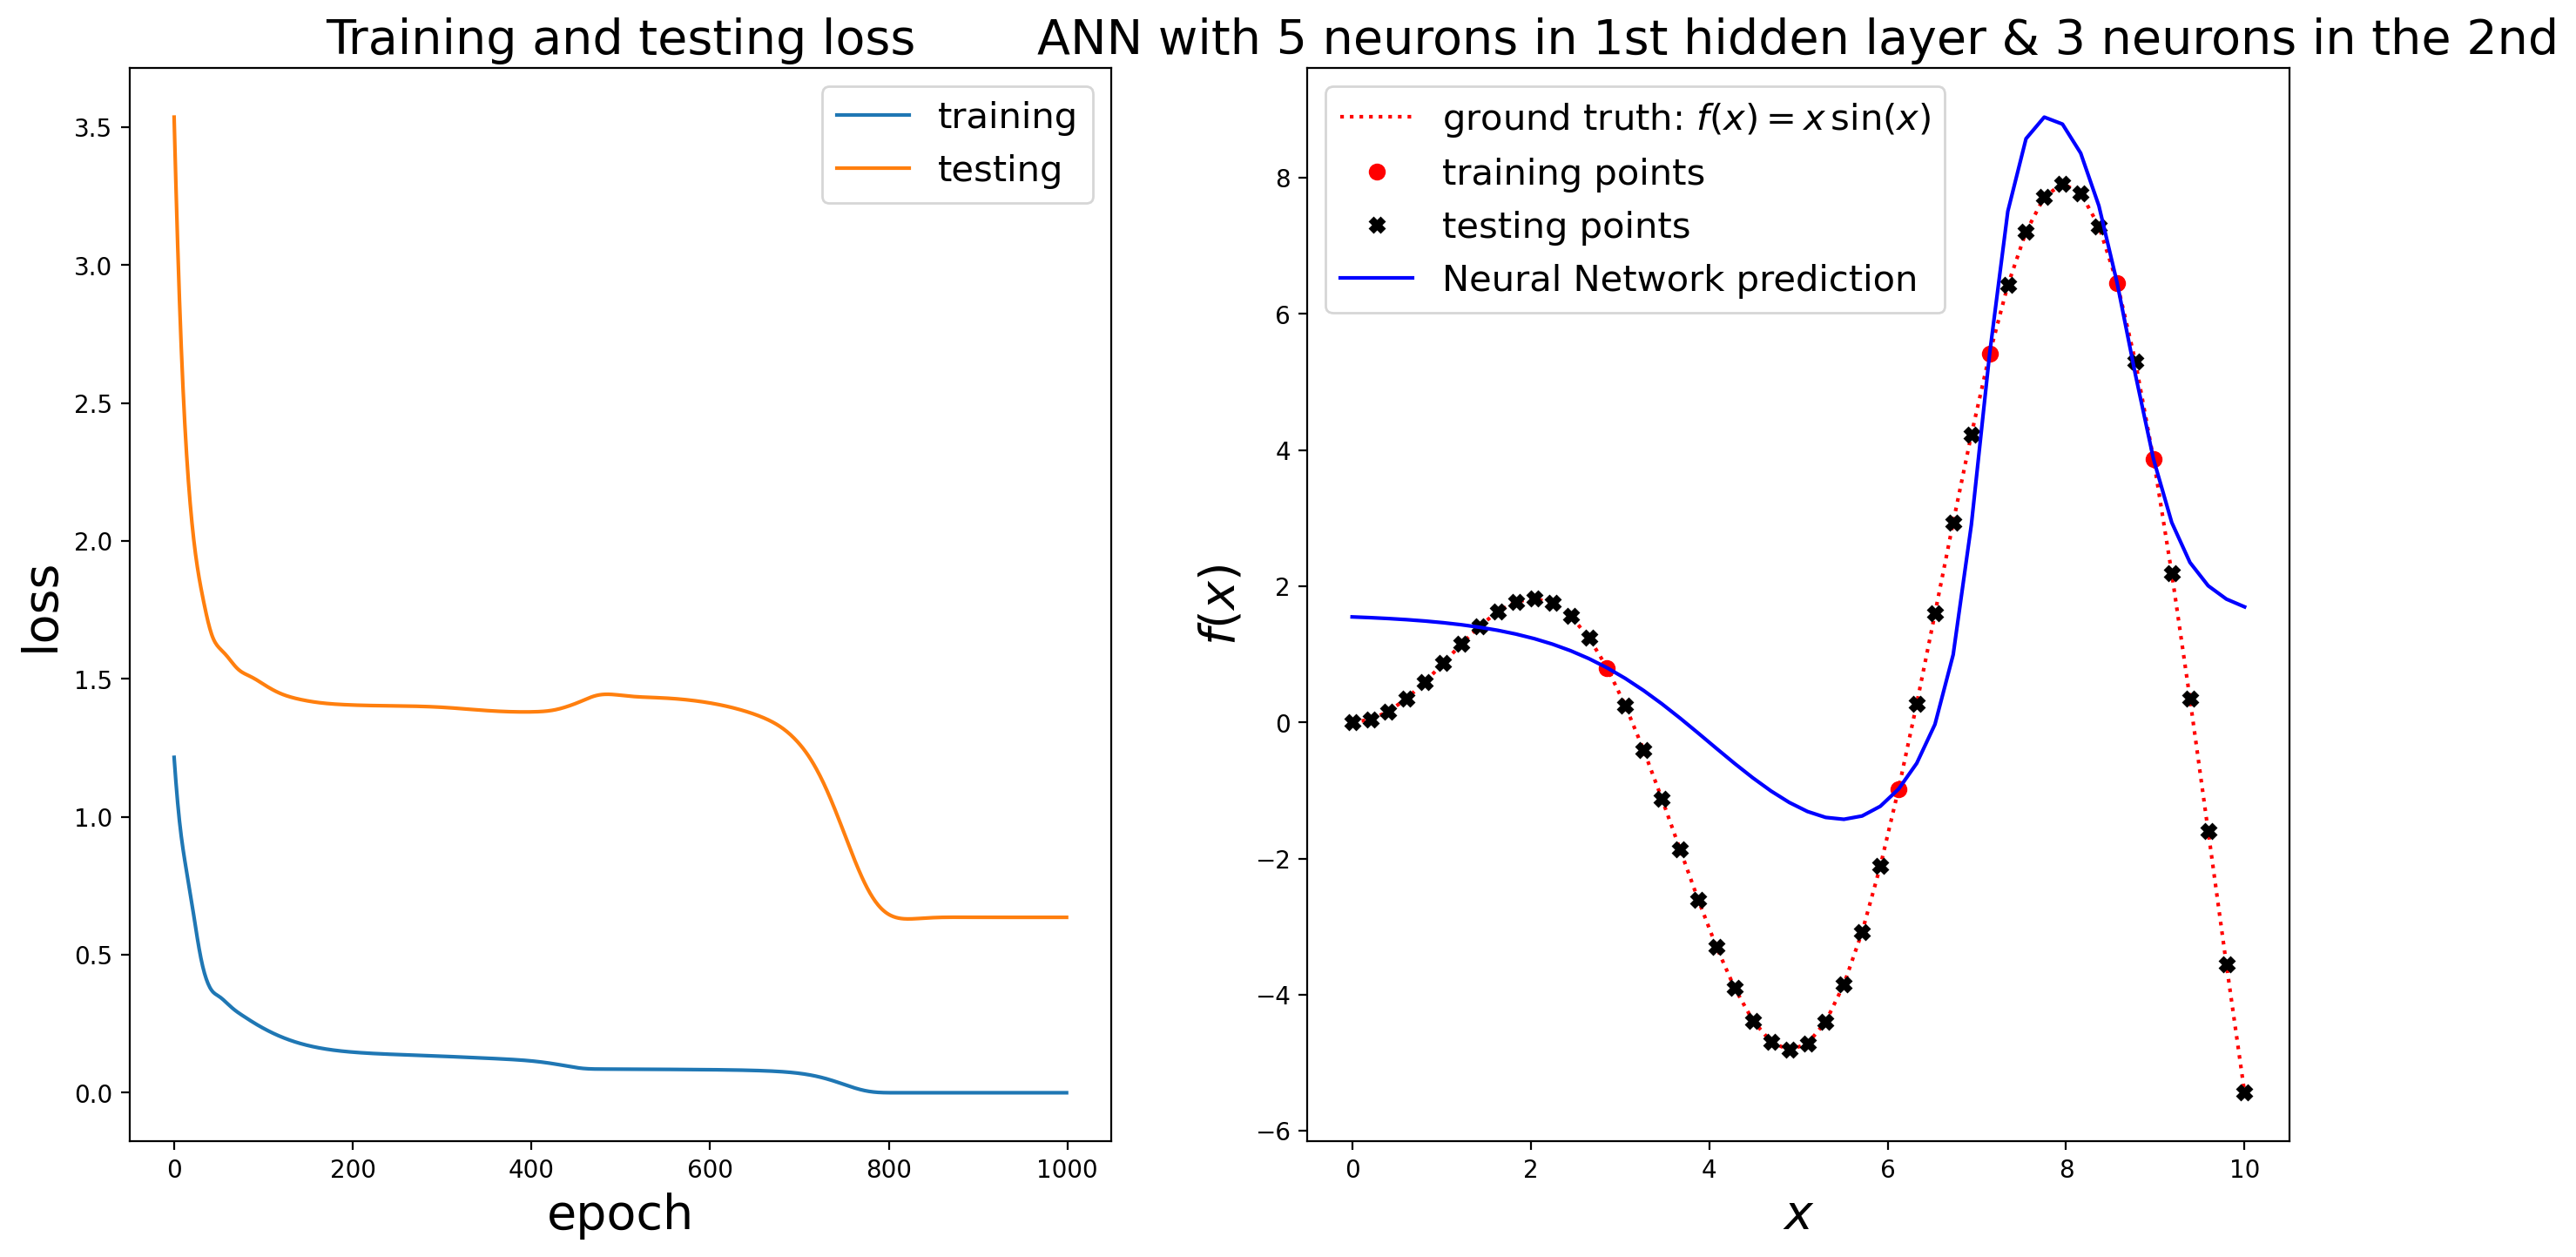

In [18]:
fig_ANN # show figure now.

A decent model but not amazing, right?

* Go back to Lecture 14 and check the prediction obtained with Gaussian Process Regression (GRP) for the same dataset.

    - GPR approximates this function better.

There's a theorem that says that a neural network with 1 hidden layer with an infinite number of neurons becomes equivalent to a Gaussian Process...

But neural networks are much more scalable than Gaussian Processes. They are not typically used for one-dimensional datasets...

### In-class exercises to gain intuition about neural networks

Play with this notebook and try different hyperparameters for the neural network.

**Note:** if you run notebook multiple times you will get different results (the weights are initialized with different values).

1. Change the activation functions of the two hidden layers to be the hyperbolic tangent: `tanh`

    - The prediction improves. Why?

2. Check what happens to the neural network prediction when you change number of neurons in the 1st hidden layer (neurons1) and in the 2nd hidden layer (neurons2) to:

    2.1 `neurons1=1` and `neurons2=1`.
    
    * The ANN prediction is not great, why? Also, the prediction becomes a very familiar function, which one and why?
    
    2.2 `neurons1=5` and `neurons2=3`.
    
    2.3. `neurons1=100` and `neurons2=100`. The prediction is similar to the case with `neurons1=5` and `neurons2=3`, why?
    
    2.4. `neurons1=1000` and `neurons2=1000`. The prediction becomes wiggly. What is going on?

3. Repeat Exercise 2.3 (only considering 100x100 neurons) but now considering a different learning rate for the Adam optimizer:

    3.1 `lr=0.0001`
    * Note that the training loss decreases slowly compared to when we used `lr=0.01`. In fact, after 1000 epochs it still does not reach zero.

    3.2 `lr=0.1`
    * Note that the training loss goes a little crazy, and that the validation loss is very large (you probably don't even need to look at the validation loss; you can simply look at the plot to see that the approximation is quite poor).
    * In Lectures 25, 26 and 27 we explained what happens with 1st order optimizers (like Adam) when the learning rate (a.k.a. step size) is too high. Do you remember?

4. Repeat Exercise 2 using the original learning rate (`lr=0.01`), but now using more training data (consider `testset_ratio = 0.75`).

    * Training with more data leads to better predictions (of course!)
    
    * Pay attention to different details that occur when training with different hyperparameters. For example:
        * When you have a network with a lot of parameters (`neurons1=100`, `neurons2=100`), it gets quickly to a training loss of 0.
        * Having a large network (with many parameters) does not mean that your prediction will be better. It depends on the dataset size, optimizer choice, activation functions, etc.
        * A training loss of zero only means that the network is interpolating the training data, but the validation loss can be worse for different models. If you have many parameters (for example, `neurons1=1000`, `neurons2=1000` leads to more than 1 million parameters), you start seeing that the prediction is wigglly and that the validation loss is higher than for simpler models. You know what happened... **Overfitting**.

5. Repeat Exercise 2 (change back to `testset_ratio = 0.90`), but now consider a network with only 1 hidden layer and with the following number of neurons:

    4.1 `neurons1=1`.
    * Again, you see the same familiar function. So, adding a second hidden layer, as done in Exercise 2.1 with 1 neuron does not improve things. Why?
    
    4.2 `neurons1=5`.
    
    4.3. `neurons1=100`.
    * It's interesting to compare this result with Exercise 2.3. The second hidden layer made the prediction more interesting when compared to this one.
    
    4.4. `neurons1=1000`.
    * It's also interesting to compare this result with Exercise 2.4. The second hidden layer made the prediction worse compared to this architecture with 1 hidden layer only.

These simple exercises should help you realize that the training dynamics of neural networks can be complex because they have many hyperparameters.

Experimenting with this method is very important to gain some intuition. You should train neural networks for different problems and datasets for regression and also classification.

Sometimes, you will still be surprised with their behavior.

**The challenge**: in practice (unless you have a lot of computational power and your problem is small), it may not be possible to do a "brute force" hyperparameter search and find the most amazing neural network for your problem.

* Experience is still important because you can narrow the hyperparameter search. For example, the problem we solved in this lecture is smooth (due to the sin function). If you knew this, you immediately knew that choosing a differentiable activation function (tanh) is better than a non-smooth one (relu).

* Another example: if you have a problem with hiearchical structure, deep neural networks (many hidden layers) have been shown to uncover data features as you get deeper in the architecture. Striking examples exist for image classification problems using a Convolutional Neural Networks.

Epoch [1/1000] Train Loss: 1.5326 | Val Loss: 14.2467
Epoch [2/1000] Train Loss: 7.2606 | Val Loss: 5.9956
Epoch [3/1000] Train Loss: 2.1112 | Val Loss: 1.9270
Epoch [4/1000] Train Loss: 1.4120 | Val Loss: 6.9305
Epoch [5/1000] Train Loss: 3.3980 | Val Loss: 7.6395
Epoch [6/1000] Train Loss: 3.2095 | Val Loss: 3.8825
Epoch [7/1000] Train Loss: 1.3611 | Val Loss: 2.2319
Epoch [8/1000] Train Loss: 0.5602 | Val Loss: 4.3342
Epoch [9/1000] Train Loss: 1.4403 | Val Loss: 6.1680
Epoch [10/1000] Train Loss: 2.2314 | Val Loss: 5.1457
Epoch [11/1000] Train Loss: 1.7975 | Val Loss: 3.0195
Epoch [12/1000] Train Loss: 0.8889 | Val Loss: 2.2026
Epoch [13/1000] Train Loss: 0.5341 | Val Loss: 2.9628
Epoch [14/1000] Train Loss: 0.8805 | Val Loss: 3.7549
Epoch [15/1000] Train Loss: 1.3195 | Val Loss: 3.4781
Epoch [16/1000] Train Loss: 1.3179 | Val Loss: 2.5116
Epoch [17/1000] Train Loss: 0.9029 | Val Loss: 1.8863
Epoch [18/1000] Train Loss: 0.5220 | Val Loss: 2.1127
Epoch [19/1000] Train Loss: 0.5382 |

Epoch [376/1000] Train Loss: 0.0007 | Val Loss: 1.3222
Epoch [377/1000] Train Loss: 0.0007 | Val Loss: 1.3218
Epoch [378/1000] Train Loss: 0.0007 | Val Loss: 1.3214
Epoch [379/1000] Train Loss: 0.0007 | Val Loss: 1.3211
Epoch [380/1000] Train Loss: 0.0007 | Val Loss: 1.3207
Epoch [381/1000] Train Loss: 0.0007 | Val Loss: 1.3203
Epoch [382/1000] Train Loss: 0.0006 | Val Loss: 1.3199
Epoch [383/1000] Train Loss: 0.0006 | Val Loss: 1.3195
Epoch [384/1000] Train Loss: 0.0006 | Val Loss: 1.3191
Epoch [385/1000] Train Loss: 0.0006 | Val Loss: 1.3187
Epoch [386/1000] Train Loss: 0.0006 | Val Loss: 1.3184
Epoch [387/1000] Train Loss: 0.0006 | Val Loss: 1.3180
Epoch [388/1000] Train Loss: 0.0006 | Val Loss: 1.3176
Epoch [389/1000] Train Loss: 0.0006 | Val Loss: 1.3173
Epoch [390/1000] Train Loss: 0.0005 | Val Loss: 1.3169
Epoch [391/1000] Train Loss: 0.0005 | Val Loss: 1.3166
Epoch [392/1000] Train Loss: 0.0005 | Val Loss: 1.3162
Epoch [393/1000] Train Loss: 0.0005 | Val Loss: 1.3159
Epoch [394

Epoch [747/1000] Train Loss: 0.0000 | Val Loss: 1.2106
Epoch [748/1000] Train Loss: 0.0000 | Val Loss: 1.2017
Epoch [749/1000] Train Loss: 0.0001 | Val Loss: 1.2128
Epoch [750/1000] Train Loss: 0.0001 | Val Loss: 1.2065
Epoch [751/1000] Train Loss: 0.0000 | Val Loss: 1.2044
Epoch [752/1000] Train Loss: 0.0000 | Val Loss: 1.2125
Epoch [753/1000] Train Loss: 0.0001 | Val Loss: 1.2037
Epoch [754/1000] Train Loss: 0.0001 | Val Loss: 1.2077
Epoch [755/1000] Train Loss: 0.0000 | Val Loss: 1.2104
Epoch [756/1000] Train Loss: 0.0000 | Val Loss: 1.2032
Epoch [757/1000] Train Loss: 0.0001 | Val Loss: 1.2100
Epoch [758/1000] Train Loss: 0.0000 | Val Loss: 1.2077
Epoch [759/1000] Train Loss: 0.0000 | Val Loss: 1.2045
Epoch [760/1000] Train Loss: 0.0000 | Val Loss: 1.2106
Epoch [761/1000] Train Loss: 0.0000 | Val Loss: 1.2054
Epoch [762/1000] Train Loss: 0.0000 | Val Loss: 1.2068
Epoch [763/1000] Train Loss: 0.0000 | Val Loss: 1.2096
Epoch [764/1000] Train Loss: 0.0000 | Val Loss: 1.2045
Epoch [765

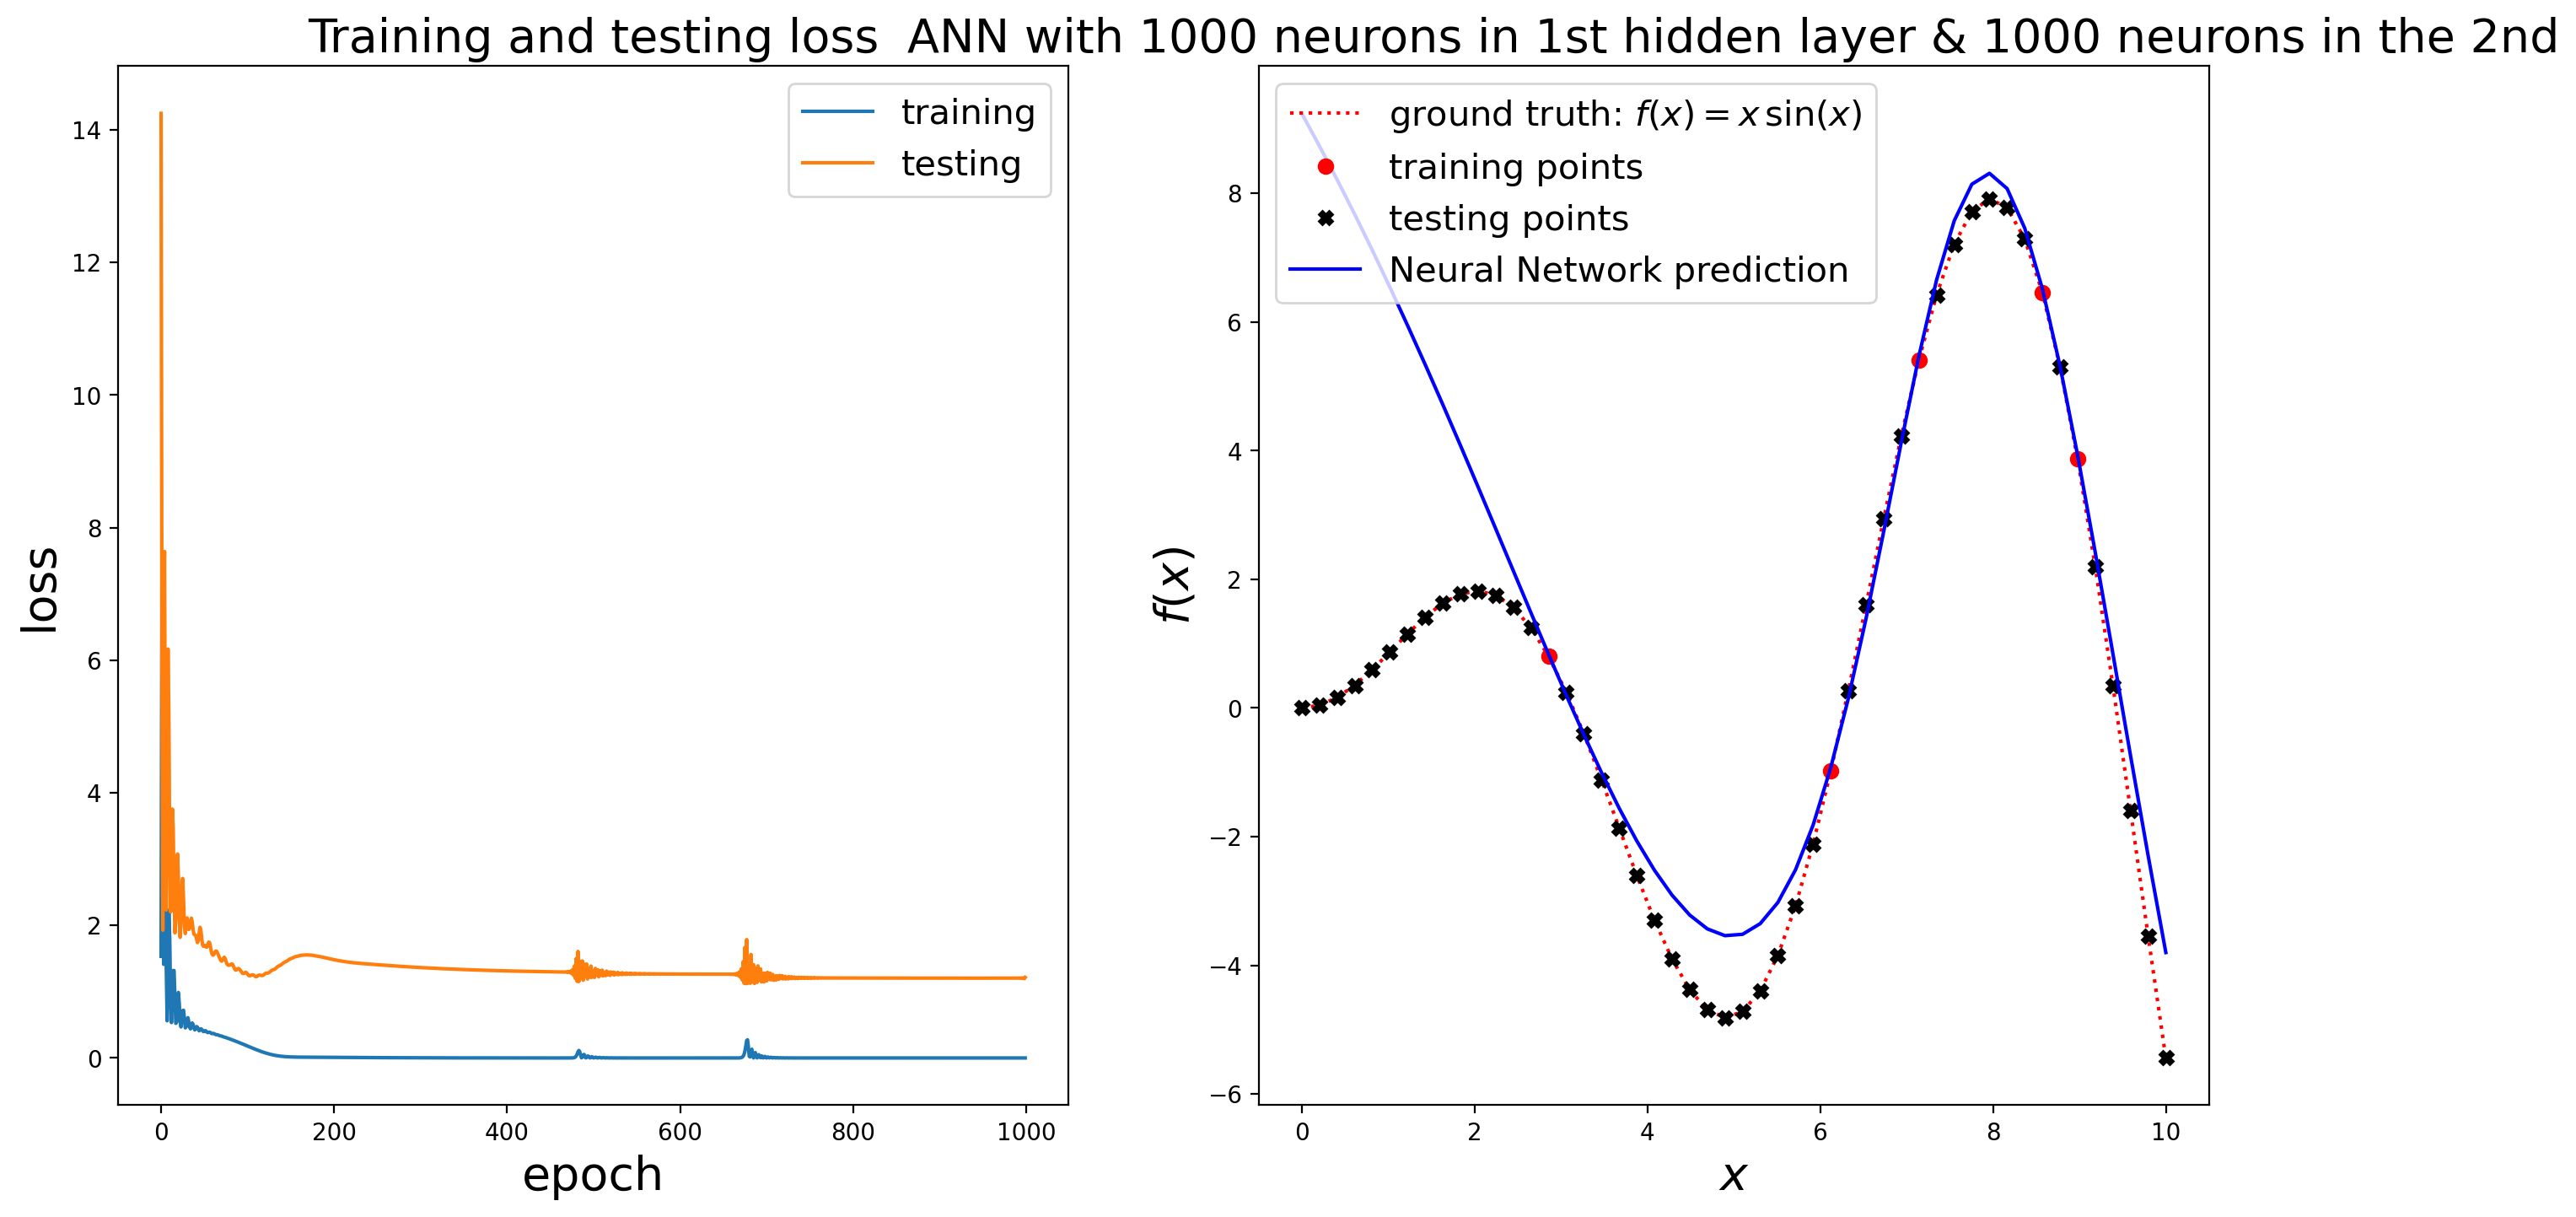

In [53]:
# Write your code for the in-class exercises here:
import torch.nn as nn # import the basic class
from torch.optim import Adam
#
class your_ANN(nn.Module):
    def __init__(self, input_dimensions=1, neurons1=3, neurons2=2, output_dimensions=1):
        super().__init__()
        
        # Pack everything into nn.Sequential
        # Here's a network with 2 hidden layers:
        self.net = nn.Sequential(
            nn.Linear(input_dimensions, neurons1),
            nn.Tanh(), # Try to change from nn.ReLU() to nn.Tanh()
            #nn.Linear(neurons1, neurons2),
            #nn.Tanh(), # Try to change from nn.ReLU() to nn.Tanh()
            #nn.Linear(neurons2, output_dimensions)
            nn.Linear(neurons1, output_dimensions)
        )
        
    def forward(self, x):
        return self.net(x)
# ---------------------------------------------------------------------
# Set hyperparameters of your_ANN
neurons1=1000 # number of neurons for the first hidden layer
neurons2=1000 # number of neurons for the second hidden layer
epochs = 1000 # number of times we train the neural network with the entire training set
your_ANN_model = your_ANN(
    input_dimensions=1,
    neurons1=neurons1,
    neurons2=neurons2,
    output_dimensions=1
)
# define the optimizer and its hyperparameters (learning rate)
optimizer = Adam(your_ANN_model.parameters(), lr=0.01,)
# ---------------------------------------------------------------------
# define the loss function (using MSE Loss for this case)
loss_fn = nn.MSELoss()
#
# Train the network and save the loss values
train_losses = []
val_losses = []
# Training loop
for epoch in range(epochs):
    # --- Training ---
    your_ANN_model.train()  # Set to training mode
    Y_train_scaled_pred = your_ANN_model(X_train_scaled)  # Forward pass
    #preds = ANN_model(torch.from_numpy(X_data).float())  # Forward pass
    loss = loss_fn(Y_train_scaled_pred, Y_train_scaled)  # Compute loss
    #loss = loss_fn(preds, torch.from_numpy(y_data).float())  # Compute loss

    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Backward pass
    optimizer.step()       # Update parameters

    train_losses.append(loss.item())  # Save training loss

    # --- Validation ---
    your_ANN_model.eval()
    with torch.no_grad():
        Y_test_scaled_pred = your_ANN_model(X_test_scaled)
        #val_preds = ANN_model(torch.from_numpy(X_test).float())
        val_loss = loss_fn(Y_test_scaled_pred, Y_test_scaled).item()

    val_losses.append(val_loss)  # Save validation loss

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")
#
# Plot the results
fig_your_ANN, (ax1_your_ANN, ax2_your_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_your_ANN.plot(train_losses) # plot training loss
ax1_your_ANN.plot(val_losses) # plot testing loss
ax1_your_ANN.set_title('Training and testing loss', fontsize=20)
ax1_your_ANN.set_ylabel('loss', fontsize=20)
ax1_your_ANN.set_xlabel('epoch', fontsize=20)
ax1_your_ANN.legend(['training', 'testing'], loc='upper right', fontsize=15)

# Create a plot for the ANN prediction
ax2_your_ANN.plot(x_data, y_data, 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_your_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_your_ANN.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # show testing data

# Let's predict all data points from our trained ANN:
Y_data_scaled_pred = your_ANN_model(X_data_scaled).detach() # detach() is to only get the values without asking for
                                                       #the complete computational graph of pytorch
Y_data_pred = scaler_y_noiseless.inverse_transform(Y_data_scaled_pred) # this is to unscale the data

ax2_your_ANN.plot(x_data, Y_data_pred.ravel(), 'b-', label="Neural Network prediction") # plot prediction
ax2_your_ANN.set_title(r'ANN with '+str(neurons1)+' neurons in 1st hidden layer & '+str(neurons2)+' neurons in the 2nd',
                 fontsize=20)
ax2_your_ANN.set_xlabel('$x$', fontsize=20)
ax2_your_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_your_ANN.legend(loc='upper left', fontsize=15)

# Create figure with specified size
fig_your_ANN.set_size_inches(16, 8)
# until here.

### See you next class

Have fun!

### Complete code to facilitate seeing everything together and to do the in-class exercises

```python
import torch.nn as nn # import the basic class
from torch.optim import Adam
#
class your_ANN(nn.Module):
    def __init__(self, input_dimensions=1, neurons1=3, neurons2=2, output_dimensions=1):
        super().__init__()
        
        # Pack everything into nn.Sequential
        self.net = nn.Sequential(
            nn.Linear(input_dimensions, neurons1),
            nn.Tanh(), # Try to change from nn.ReLU() to nn.Tanh()
            nn.Linear(neurons1, neurons2),
            nn.Tanh(), # Try to change from nn.ReLU() to nn.Tanh()
            nn.Linear(neurons2, output_dimensions)
        )
        
    def forward(self, x):
        return self.net(x)
# ---------------------------------------------------------------------
# Set hyperparameters of your_ANN
neurons1=5 # number of neurons for the first hidden layer
neurons2=3 # number of neurons for the second hidden layer
epochs = 1000 # number of times we train the neural network with the entire training set
your_ANN_model = your_ANN(
    input_dimensions=1,
    neurons1=neurons1,
    neurons2=neurons2,
    output_dimensions=1
)
# define the optimizer and its hyperparameters (learning rate)
optimizer = Adam(your_ANN_model.parameters(), lr=0.01,)
# ---------------------------------------------------------------------
# define the loss function (using MSE Loss for this case)
loss_fn = nn.MSELoss()
#
# Train the network and save the loss values
train_losses = []
val_losses = []
# Training loop
for epoch in range(epochs):
    # --- Training ---
    your_ANN_model.train()  # Set to training mode
    Y_train_scaled_pred = your_ANN_model(X_train_scaled)  # Forward pass
    #preds = ANN_model(torch.from_numpy(X_data).float())  # Forward pass
    loss = loss_fn(Y_train_scaled_pred, Y_train_scaled)  # Compute loss
    #loss = loss_fn(preds, torch.from_numpy(y_data).float())  # Compute loss

    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Backward pass
    optimizer.step()       # Update parameters

    train_losses.append(loss.item())  # Save training loss

    # --- Validation ---
    your_ANN_model.eval()
    with torch.no_grad():
        Y_test_scaled_pred = your_ANN_model(X_test_scaled)
        #val_preds = ANN_model(torch.from_numpy(X_test).float())
        val_loss = loss_fn(Y_test_scaled_pred, Y_test_scaled).item()

    val_losses.append(val_loss)  # Save validation loss

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss:.4f}")
#
# Plot the results
fig_your_ANN, (ax1_your_ANN, ax2_your_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_your_ANN.plot(train_losses) # plot training loss
ax1_your_ANN.plot(val_losses) # plot testing loss
ax1_your_ANN.set_title('Training and testing loss', fontsize=20)
ax1_your_ANN.set_ylabel('loss', fontsize=20)
ax1_your_ANN.set_xlabel('epoch', fontsize=20)
ax1_your_ANN.legend(['training', 'testing'], loc='upper right', fontsize=15)

# Create a plot for the ANN prediction
ax2_your_ANN.plot(x_data, y_data, 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_your_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_your_ANN.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # show testing data

# Let's predict all data points from our trained ANN:
Y_data_scaled_pred = your_ANN_model(X_data_scaled).detach() # detach() is to only get the values without asking for
                                                       #the complete computational graph of pytorch
Y_data_pred = scaler_y_noiseless.inverse_transform(Y_data_scaled_pred) # this is to unscale the data

ax2_your_ANN.plot(x_data, Y_data_pred.ravel(), 'b-', label="Neural Network prediction") # plot prediction
ax2_your_ANN.set_title(r'ANN with '+str(neurons1)+' neurons in 1st hidden layer & '+str(neurons2)+' neurons in the 2nd',
                 fontsize=20)
ax2_your_ANN.set_xlabel('$x$', fontsize=20)
ax2_your_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_your_ANN.legend(loc='upper left', fontsize=15)

# Create figure with specified size
fig_your_ANN.set_size_inches(16, 8)
plt.close(fig_your_ANN) # do not plot the figure now. We will show it in the next cell
```